In [1]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from timm.models import safe_model_name, set_fast_norm

In [2]:
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

## Config

In [3]:
DATA_PATH = Path('/data/')
CSV_PATH = DATA_PATH/'train.csv'
IMAGE_FOLDER = DATA_PATH/'train'
FOLDS_PATH = DATA_PATH/'train_folds.csv'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

VERSION = "NB_EXP_V2_011"
MODEL = "tf_efficientnetv2_m_in21ft1k"
BS = 32; SZ = 480

MODEL_FOLDER = Path(f"/runs/{VERSION}/")
MODEL_FOLDER.mkdir(exist_ok=True)

In [4]:
folds = pd.read_csv(FOLDS_PATH)
folds['fold'] = folds['fold'].astype(int)
folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


## Define Dataset

In [5]:
def get_dls(fold:int):
    folds['is_valid'] = folds['fold'] == fold
    item_tfms = [Resize(SZ+16, method=ResizeMethod.Squish), ToTensor]

    augments = aug_transforms(do_flip=True, flip_vert=True, max_rotate=360, max_zoom=1.33, max_lighting=0.1, 
                              p_affine=0.5,  p_lighting=0.5, pad_mode="zeros", xtra_tfms=[RandomErasing(p=0.75)])
    batch_tfms = [IntToFloatTensor, RandomResizedCrop(SZ, min_scale=0.72), *augments, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = ColSplitter(col='is_valid'),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=BS)
    return dls

## Visualization

In [6]:
dls = get_dls(0)

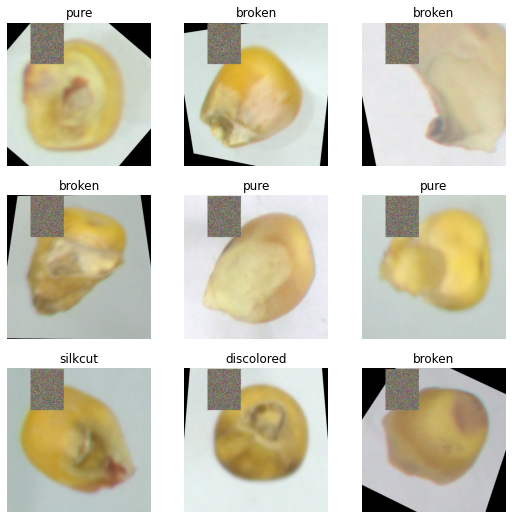

In [7]:
dls.show_batch()

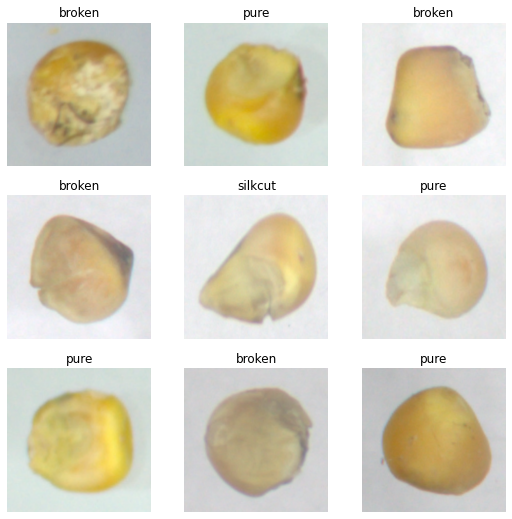

In [8]:
dls.valid.show_batch()

## Learner

In [9]:
def get_learner(fold, model_name, pretrained, **kwargs):
    dls = get_dls(fold)
    
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, len(LABELS)))
    
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn

In [10]:
# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
#     dls, learn = get_learner(0, MODEL, pretrained=True)
#     learn.unfreeze()
#     print(learn.lr_find())

## Run !

In [11]:
EP = 16; LR = 3e-4
KERNEL_TYPE = f"{MODEL}_{SZ}_bs{BS}_ep{EP}_lr{str(LR).replace('-','')}_mixup_fastai"
print(KERNEL_TYPE)

tf_efficientnetv2_m_in21ft1k_480_bs32_ep16_lr0.0003_mixup_fastai


In [12]:
def training_loop(fold):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print('*' * 100)
        print(f'Training fold {fold}')
        print('*' * 100)

        cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater), MixUp(alpha=0.4)]
        
        dls, learn = get_learner(fold, MODEL, pretrained=True)
        learn.unfreeze()
            
        learn.fit_one_cycle(EP, LR, cbs=cbs)

        learn = learn.load("model")
        learn = learn.to_fp32()

        dirpath = MODEL_FOLDER/f'{KERNEL_TYPE}_CV_{fold_idx}'
        learn.save(dirpath, with_opt=False)

In [ ]:
for fold_idx in range(5):
    training_loop(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,0.981615,0.816022,0.666318,03:02
1,0.896399,0.714710,0.718674,03:02
2,0.908535,0.754745,0.706806,03:02
3,0.873683,0.713625,0.705759,03:02
4,0.852487,0.635102,0.746597,03:02
5,0.849846,0.646223,0.738569,03:02
6,0.826387,0.594852,0.766841,03:02
7,0.802207,0.546482,0.776963,03:02


Better model found at epoch 0 with accuracy value: 0.6663176417350769.
Better model found at epoch 1 with accuracy value: 0.7186736464500427.
Better model found at epoch 4 with accuracy value: 0.7465968728065491.
Better model found at epoch 6 with accuracy value: 0.7668411731719971.
Better model found at epoch 7 with accuracy value: 0.7769633531570435.


In [ ]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [ ]:
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold in range(5):
        CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
        print(f'=> load from : {CHECKPOINT}')
        
        dls, learn = get_learner(fold, MODEL, pretrained=False)

        learn.model.load_state_dict(torch.load(CHECKPOINT))

        tst_dl = dls.valid.new()
        
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

In [ ]:
#!cp -r '/content/NB_EXP_V2_004/' '/content/drive/MyDrive'